In [1]:
import pandas as pd
from sklearn.preprocessing import QuantileTransformer

def count_cbc_cases(data):
    comp_data = data.query("~(WBC.isnull() & HGB.isnull() & MCV.isnull() & PLT.isnull() & RBC.isnull())",
                           engine='python')
    unique_data = comp_data.drop_duplicates(subset=["Id", "Center"])
    return len(unique_data)


def count_cbc(data):
    comp_data = data.query("~(WBC.isnull() & HGB.isnull() & MCV.isnull() & PLT.isnull() & RBC.isnull())",
                           engine='python')
    return len(comp_data)


class Features:
    def __init__(self, data):
        unique_data = data.drop_duplicates(subset=["Id", "Center", "Time"], keep=False)
        non_icu_unique_data = unique_data.query("~(Sender.str.contains('ICU')) & ~(~SecToIcu.isnull() & SecToIcu < 0)",
                                                engine='python')
        first_non_icu_unique_data = non_icu_unique_data.query("Episode == 1 ", engine='python')
        complete_first_non_icu_unique_data = first_non_icu_unique_data.query("~(WBC.isnull() | HGB.isnull() | "
                                                                             "MCV.isnull() | PLT.isnull() | "
                                                                             "RBC.isnull())", engine='python')
        sirs_complete_first_non_icu_unique_data = complete_first_non_icu_unique_data.query("Diagnosis != 'SIRS'",
                                                                                           engine='python')
        sirs_complete_first_non_icu_unique_data = \
            sirs_complete_first_non_icu_unique_data.query("(Diagnosis == 'Control') | ((Diagnosis == 'Sepsis') & ("
                                                          "~TargetIcu.isnull() & "
                                                          "TargetIcu.str.contains('MICU')))",
                                                                                           engine='python')
        self.data = sirs_complete_first_non_icu_unique_data
        self.data['Label'] = self.data['Diagnosis']

        control_filter = (self.data["Diagnosis"] == 'Control') | \
                         ((self.data["SecToIcu"] > 3600 * 6) & (
                                     ~self.data["TargetIcu"].isnull() & self.data["TargetIcu"]
                                     .str.contains('MICU', na=False)))
        sepsis_filter = (self.data["Diagnosis"] == 'Sepsis') & \
                        (self.data["SecToIcu"] <= 3600 * 6) & \
                        (self.data["TargetIcu"].str.contains('MICU', na=False))
        self.data.loc[control_filter, "Label"] = "Control"
        self.data.loc[sepsis_filter, "Label"] = "Sepsis"

        self.control_data = self.data.loc[control_filter]
        self.sepsis_data = self.data.loc[sepsis_filter]

    def get_x(self):
        feature_columns = ["Age","Sex", "HGB", "PLT", "RBC", "WBC", "MCV"]
        return self.data.loc[:, feature_columns].replace(to_replace='W', value=1).replace(to_replace='M', value=0)#QuantileTransformer(n_quantiles=100).fit_transform(

    def get_y(self):
        return (self.data["Label"] == "Sepsis").astype(int) #self.data.loc[:, "Label"]

    def get_control_data(self):
        return self.control_data

    def get_sepsis_data(self):
        return self.sepsis_data

    def get_data(self):
        return self.data.sample(frac=1).reset_index()


In [2]:
class Training(Features):
    def __init__(self, data):
        leipzig_training_data = data.query("Center == 'Leipzig' & Set == 'Training'")
        Features.__init__(self, leipzig_training_data)


In [3]:
class Validation(Features):
    def __init__(self, data):
        leipzig_validation_data = data.query("Center == 'Leipzig' & Set == 'Validation'")
        Features.__init__(self, leipzig_validation_data)

In [4]:
class GreifswaldValidation(Features):
    def __init__(self, data):
        greifswald_validation_data = data.query("Center == 'Greifswald' & Set == 'Validation'")
        Features.__init__(self, greifswald_validation_data)

In [5]:
# TODO Implement greifswald validation
class DataAnalysis:
    def __init__(self, data):
        self.training = Training(data)
        print("Training: ")
        print(f"Assessable data are {count_cbc_cases(self.training.get_data())} cases "
              f"and {count_cbc(self.training.get_data())} CBCs")
        print(f"Control data are {count_cbc_cases(self.training.get_control_data())} cases "
              f"and {count_cbc(self.training.get_control_data())} CBCs")
        print(f"Sepsis data are {count_cbc_cases(self.training.get_sepsis_data())} cases "
              f"and {count_cbc(self.training.get_sepsis_data())} CBCs")
        print(20 * "$")
        print("Testing: ")
        self.validation = Validation(data)
        print(f"Controls: {self.validation.get_control_data().shape[0]},"
              f" Sepsis: {self.validation.get_sepsis_data().shape[0]}")
        print(f"Assessable data are {count_cbc_cases(self.validation.get_data())} cases "
              f"and {count_cbc(self.validation.get_data())} CBCs")
        print(f"Control data are {count_cbc_cases(self.validation.get_control_data())} cases "
              f"and {count_cbc(self.validation.get_control_data())} CBCs")
        print(f"Sepsis data are {count_cbc_cases(self.validation.get_sepsis_data())} cases "
              f"and {count_cbc(self.validation.get_sepsis_data())} CBCs")

        self.greifswald_vaidation = GreifswaldValidation(data)
        print(f"Controls: {self.greifswald_vaidation.get_control_data().shape[0]},"
              f" Sepsis: {self.greifswald_vaidation.get_sepsis_data().shape[0]}")
        print(f"Assessable data are {count_cbc_cases(self.greifswald_vaidation.get_data())} cases "
              f"and {count_cbc(self.greifswald_vaidation.get_data())} CBCs")
        print(f"Control data are {count_cbc_cases(self.validation.get_control_data())} cases "
              f"and {count_cbc(self.greifswald_vaidation.get_control_data())} CBCs")
        print(f"Sepsis data are {count_cbc_cases(self.greifswald_vaidation.get_sepsis_data())} cases "
              f"and {count_cbc(self.greifswald_vaidation.get_sepsis_data())} CBCs")

    def get_training_data(self):
        return self.training.get_data()

    def get_testing_data(self):
        return self.validation.get_data()
    
    def get_gw_testing_data(self):
        return self.greifswald_vaidation.get_data()


In [6]:
data = pd.read_csv(r"extdata/sbcdata.csv", header=0)
# data = pd.read_csv(r"extdata/sbc_small.csv", header=0)
data_analysis = DataAnalysis(data)

training = data_analysis.get_training_data()
testing = data_analysis.get_testing_data()

/tmp/ipykernel_297382/2913398120.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Training: 
Assessable data are 528101 cases and 1015074 CBCs
Control data are 527038 cases and 1013548 CBCs
Sepsis data are 1488 cases and 1526 CBCs
$$$$$$$$$$$$$$$$$$$$
Testing: 


/tmp/ipykernel_297382/2913398120.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 365794, Sepsis: 490
Assessable data are 180494 cases and 366284 CBCs
Control data are 180157 cases and 365794 CBCs
Sepsis data are 472 cases and 490 CBCs


/tmp/ipykernel_297382/2913398120.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']


Controls: 437629, Sepsis: 448
Assessable data are 157922 cases and 438077 CBCs
Control data are 180157 cases and 437629 CBCs
Sepsis data are 438 cases and 448 CBCs


## Constants

In [96]:
HGB_COLUMN_NAME = "HGB"
WBC_COLUMN_NAME = "WBC"
RBC_COLUMN_NAME = "RBC"
MCV_COLUMN_NAME = "MCV"
PLT_COLUMN_NAME = "PLT"
ID_COLUMN = "Id"

SEX_COLUMN_NAME = "Sex"
W_COLUMN_NAME = "W"
M_COLUMN_NAME = "M"
AGE_COLUMN_NAME = "Age"
PATIENT_NAME = "PATIENT"
EDGE_TYPE = "HAS"
REV_EDGE_TYPE = "rev_HAS"
LABEL_COLUMN_NAME = "Label"
TIME_SERIES_LABEL = "TimeSeriesLabel"

FEATURES = [AGE_COLUMN_NAME, SEX__CAT_COLUMN_NAME, HGB_COLUMN_NAME, WBC_COLUMN_NAME, RBC_COLUMN_NAME,
                               MCV_COLUMN_NAME, PLT_COLUMN_NAME]

In [97]:
import numpy as np
unique_ids, unique_id_counts = np.unique(train_data[ID_COLUMN], return_counts=True)
single_id_in_unqiue_mask = unique_id_counts == 1
single_id_mask = np.isin(train_data[ID_COLUMN].to_numpy(), unique_ids[single_id_in_unqiue_mask])

In [98]:
multi_id_train_data = train_data[np.logical_not(single_id_mask)]
multi_id_train_data.shape

(641976, 21)

In [99]:
unique, index = np.unique(multi_id_train_data[ID_COLUMN], return_index=True)
unique.shape, index.shape

((155003,), (155003,))

In [194]:
unique_ids, unique_id_counts = np.unique(train_data[ID_COLUMN], return_counts=True)
duo_id_in_unqiue_mask = unique_id_counts == 2
duo_id_mask = np.isin(train_data[ID_COLUMN].to_numpy(), unique_ids[duo_id_in_unqiue_mask])
duo_id_train_data = train_data[duo_id_mask]
np.unique(duo_id_train_data[ID_COLUMN], return_counts=True)

(array([     5,     27,     40, ..., 583800, 583808, 583814]),
 array([2, 2, 2, ..., 2, 2, 2]))

In [250]:
multi_id_train_data

,index,Id,Age,Sex,Diagnosis,Center,Set,Sender,Episode,Time,...,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,Label,SexCat
0,1989993,510336,46,M,Control,Leipzig,Training,GEN,1,0.0,...,NaN,2.74,6.4,100.7,NaN,121.0,2.83,7.8,Control,0
1,1263825,230375,40,W,Control,Leipzig,Training,AMB,1,5261280.0,...,NaN,2.98,8.7,97.3,NaN,196.0,4.43,8.0,Control,1
3,2040311,529075,43,M,Control,Leipzig,Training,GEN,1,43560.0,...,NaN,7.54,8.3,82.9,NaN,168.0,4.56,12.0,Control,0
4,1697140,397599,65,M,Control,Leipzig,Training,AMB,1,2848500.0,...,NaN,NaN,6.4,101.2,NaN,78.0,3.28,10.2,Control,0
5,1917287,482257,74,M,Control,Leipzig,Training,GEN,1,0.0,...,NaN,5.54,9.2,90.4,NaN,305.0,4.80,6.9,Control,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015067,1627719,371481,59,W,Control,Leipzig,Training,AMB,1,5968080.0,...,NaN,NaN,6.3,99.3,NaN,276.0,3.06,5.0,Control,1
1015068,1864945,461536,78,W,Control,Leipzig,Training,GEN,1,1199700.0,...,NaN,62.03,5.5,86.3,NaN,42.0,2.93,0.9,Control,1
1015069,2086329,547060,76,W,Control,Leipzig,Training,GEN,1,1048560.0,...,NaN,67.97,5.2,93.0,NaN,163.0,2.86,5.9,Control,1
1015071,974497,119182,77,M,Control,Leipzig,Training,GEN,1,58980.0,...,NaN,14.56,7.2,87.3,NaN,244.0,3.95,9.9,Control,0


In [260]:
grouped_multi_id_df = duo_id_train_data.groupby(ID_COLUMN).agg(lambda x: x.tolist())

In [261]:
def sort_df_based_on_column(df, column):
    columns = df.columns
    def sort_row(row):
        indices = np.argsort(row[column])
        return [list(np.array(col)[indices]) for col in row]

    df = df.apply(sort_row, axis=1)
    df = pd.DataFrame({column: [row[i] for row in df] for i, column in enumerate(columns)})
    return df

grouped_multi_id_df = sort_df_based_on_column(grouped_multi_id_df, "Time")

In [262]:
grouped_multi_id_df

,index,Age,Sex,Diagnosis,Center,Set,Sender,Episode,Time,TargetIcu,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,Label,SexCat
0,"[665591, 665592]","[63, 63]","[W, W]","[Control, Control]","[Leipzig, Leipzig]","[Training, Training]","[GEN, GEN]","[1, 1]","[0.0, 540060.0]","[nan, nan]","[nan, nan]","[232.87, 13.32]","[7.4, 6.5]","[86.6, 90.2]","[nan, nan]","[189.0, 349.0]","[3.96, 3.56]","[20.9, 7.1]","[Control, Control]","[1, 1]"
1,"[665640, 665641]","[35, 35]","[W, W]","[Control, Control]","[Leipzig, Leipzig]","[Training, Training]","[GEN, GEN]","[1, 1]","[0.0, 70680.0]","[nan, nan]","[nan, nan]","[6.61, nan]","[7.1, 6.5]","[88.7, 88.5]","[nan, nan]","[183.0, 177.0]","[3.72, 3.4]","[10.7, 12.0]","[Control, Control]","[1, 1]"
2,"[665660, 665661]","[38, 38]","[W, W]","[Control, Control]","[Leipzig, Leipzig]","[Training, Training]","[GEN, GEN]","[1, 1]","[0.0, 41640.0]","[nan, nan]","[nan, nan]","[nan, nan]","[7.4, 7.0]","[85.4, 87.7]","[nan, nan]","[329.0, 302.0]","[3.83, 3.66]","[12.7, 11.3]","[Control, Control]","[1, 1]"
3,"[665738, 665739]","[35, 35]","[W, W]","[Control, Control]","[Leipzig, Leipzig]","[Training, Training]","[GEN, GEN]","[1, 1]","[0.0, 334200.0]","[nan, nan]","[nan, nan]","[1.06, 0.58]","[5.5, 5.4]","[67.7, 67.7]","[nan, nan]","[391.0, 391.0]","[4.3, 4.33]","[5.6, 6.0]","[Control, Control]","[1, 1]"
4,"[665744, 665745]","[52, 52]","[M, M]","[Control, Control]","[Leipzig, Leipzig]","[Training, Training]","[GEN, GEN]","[1, 1]","[0.0, 253860.0]","[nan, nan]","[nan, nan]","[0.63, 96.19]","[9.2, 8.8]","[84.6, 86.4]","[nan, nan]","[279.0, 228.0]","[5.05, 4.85]","[4.9, 12.8]","[Control, Control]","[0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69561,"[2180883, 2180884]","[76, 76]","[W, W]","[Control, Control]","[Leipzig, Leipzig]","[Training, Training]","[GEN, GEN]","[1, 1]","[0.0, 75600.0]","[nan, nan]","[nan, nan]","[3.58, 2.35]","[8.2, 7.8]","[82.1, 82.4]","[nan, nan]","[275.0, 246.0]","[4.69, 4.44]","[5.6, 5.2]","[Control, Control]","[1, 1]"
69562,"[2180906, 2180907]","[35, 35]","[W, W]","[Control, Control]","[Leipzig, Leipzig]","[Training, Training]","[GEN, GEN]","[1, 1]","[0.0, 136860.0]","[nan, nan]","[nan, nan]","[nan, nan]","[7.1, 7.4]","[86.3, 83.3]","[nan, nan]","[177.0, 183.0]","[3.87, 4.0]","[11.6, 17.0]","[Control, Control]","[1, 1]"
69563,"[2180911, 2180912]","[82, 82]","[W, W]","[Control, Control]","[Leipzig, Leipzig]","[Training, Training]","[GEN, GEN]","[1, 1]","[0.0, 1019160.0]","[nan, nan]","[nan, nan]","[9.18, nan]","[7.1, 7.7]","[87.6, 86.1]","[nan, nan]","[234.0, 245.0]","[4.12, 4.32]","[5.9, 5.9]","[Control, Control]","[1, 1]"
69564,"[2180922, 2180923]","[26, 26]","[W, W]","[Control, Control]","[Leipzig, Leipzig]","[Training, Training]","[ED, ED]","[1, 1]","[1020.0, 19320.0]","[MICU, MICU]","[24240.0, 5940.0]","[nan, nan]","[7.9, 8.2]","[87.9, 88.0]","[nan, nan]","[454.0, 426.0]","[4.46, 4.58]","[23.3, 29.7]","[Control, Control]","[1, 1]"


In [263]:
sepsis_mask = grouped_multi_id_df[LABEL_COLUMN_NAME].apply(lambda x: "Sepsis" in x)
grouped_multi_id_df[TIME_SERIES_LABEL] = sepsis_mask.astype(int)
feature_df = grouped_multi_id_df[FEATURES]

In [270]:
import torch
age_tensor = torch.tensor(feature_df[AGE_COLUMN_NAME].tolist())
wbc_tensor = torch.tensor(feature_df[WBC_COLUMN_NAME].tolist())
plt_tensor = torch.tensor(feature_df[PLT_COLUMN_NAME].tolist())
sex_tensor = torch.tensor(feature_df[SEX__CAT_COLUMN_NAME].tolist())
mcv_tensor = torch.tensor(feature_df[MCV_COLUMN_NAME].tolist())
hgb_tensor = torch.tensor(feature_df[HGB_COLUMN_NAME].tolist())
rbc_tensor = torch.tensor(feature_df[RBC_COLUMN_NAME].tolist())
X_train = torch.cat((age_tensor.unsqueeze(2), wbc_tensor.unsqueeze(2), plt_tensor.unsqueeze(2),
          sex_tensor.unsqueeze(2), mcv_tensor.unsqueeze(2), hgb_tensor.unsqueeze(2),
           rbc_tensor.unsqueeze(2)), dim = 2)
y_train = torch.from_numpy(grouped_multi_id_df[TIME_SERIES_LABEL].to_numpy())
print(X_train.shape)

torch.Size([69566, 2, 7])


In [283]:
print(np.unique(y_train, return_counts=True))

(array([0, 1]), array([69498,    68]))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.type(torch.float32)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Generate some example data
# X_train = np.random.rand(100, 10, 1)
# y_train = np.random.randint(0, 2, size=(100,))

# # Convert data to PyTorch tensors
# X_train = torch.from_numpy(X_train).float()
# y_train = torch.from_numpy(y_train).long()
X_train = X_train.type(torch.double)
# Initialize the model
input_dim = 7
hidden_dim = 16
output_dim = 2
model = LSTMClassifier(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() #weight=torch.tensor([1, 1000])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    print(loss)
    optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Test the model
outputs = model(X_train)
_, predicted = torch.max(outputs.data, 1)
print('Predicted labels:', (predicted == y_train).sum())


tensor(0.3857, grad_fn=<NllLossBackward0>)
Epoch [1/100], Loss: 0.3857
tensor(0.3788, grad_fn=<NllLossBackward0>)
Epoch [2/100], Loss: 0.3788
tensor(0.3721, grad_fn=<NllLossBackward0>)
Epoch [3/100], Loss: 0.3721
tensor(0.3657, grad_fn=<NllLossBackward0>)
Epoch [4/100], Loss: 0.3657
tensor(0.3596, grad_fn=<NllLossBackward0>)
Epoch [5/100], Loss: 0.3596
tensor(0.3537, grad_fn=<NllLossBackward0>)
Epoch [6/100], Loss: 0.3537
tensor(0.3480, grad_fn=<NllLossBackward0>)
Epoch [7/100], Loss: 0.3480
tensor(0.3426, grad_fn=<NllLossBackward0>)
Epoch [8/100], Loss: 0.3426
tensor(0.3373, grad_fn=<NllLossBackward0>)
Epoch [9/100], Loss: 0.3373
tensor(0.3322, grad_fn=<NllLossBackward0>)
Epoch [10/100], Loss: 0.3322
tensor(0.3272, grad_fn=<NllLossBackward0>)
Epoch [11/100], Loss: 0.3272
tensor(0.3225, grad_fn=<NllLossBackward0>)
Epoch [12/100], Loss: 0.3225
tensor(0.3179, grad_fn=<NllLossBackward0>)
Epoch [13/100], Loss: 0.3179
tensor(0.3135, grad_fn=<NllLossBackward0>)
Epoch [14/100], Loss: 0.3135
t

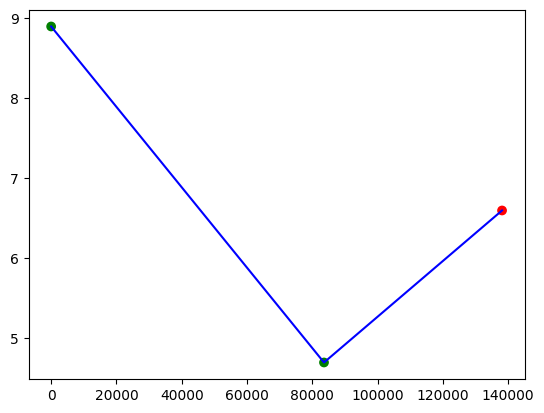

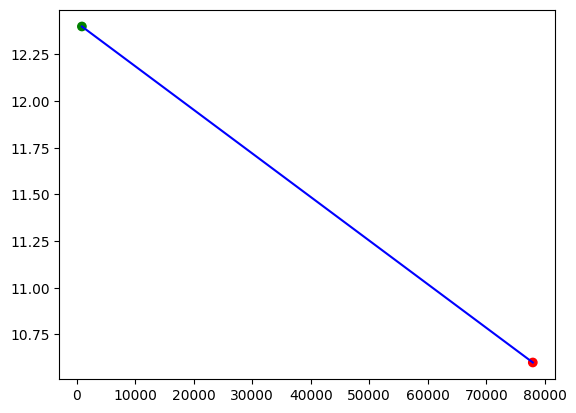

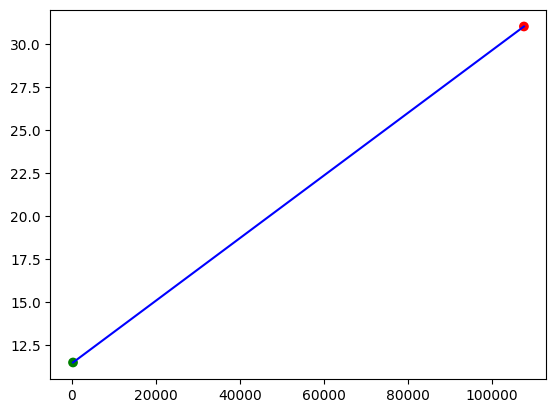

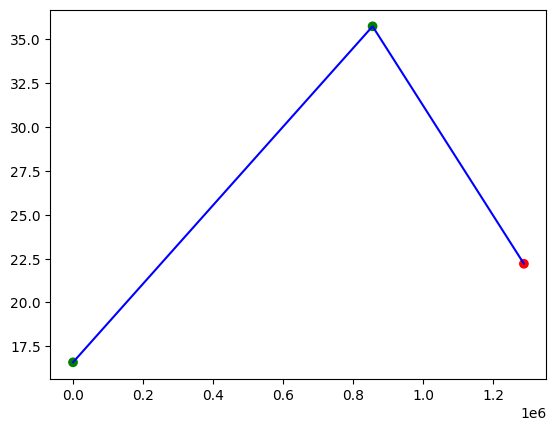

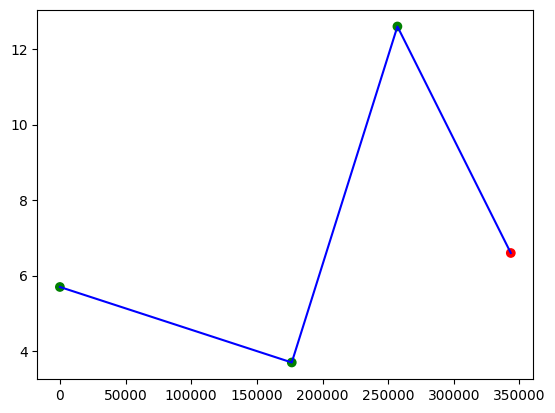

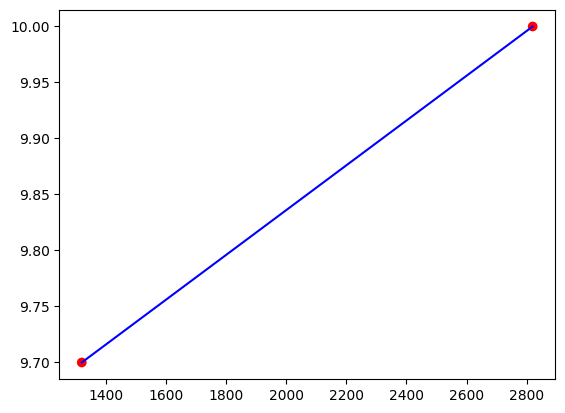

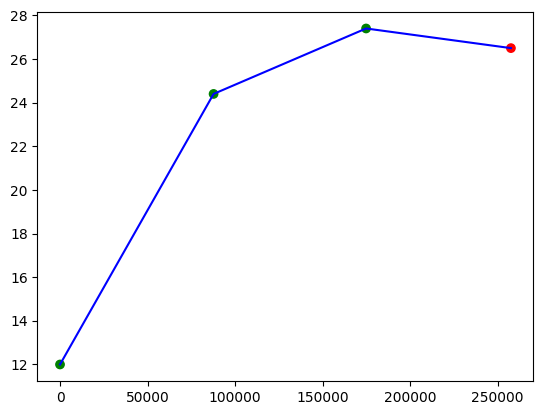

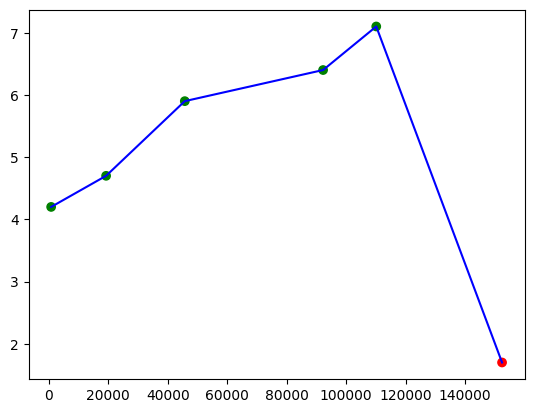

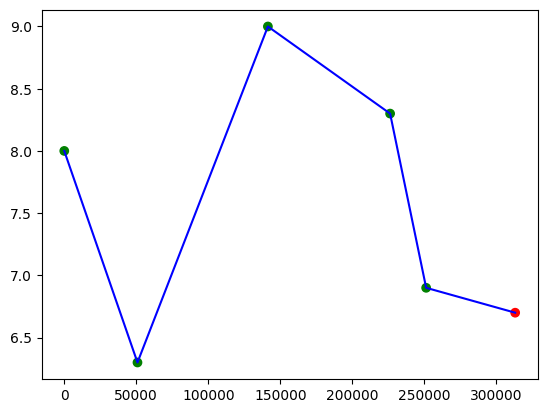

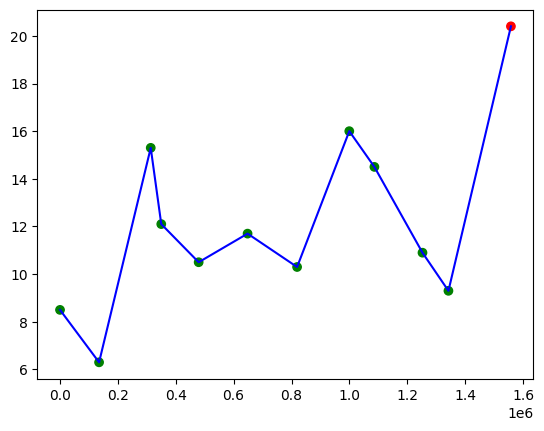

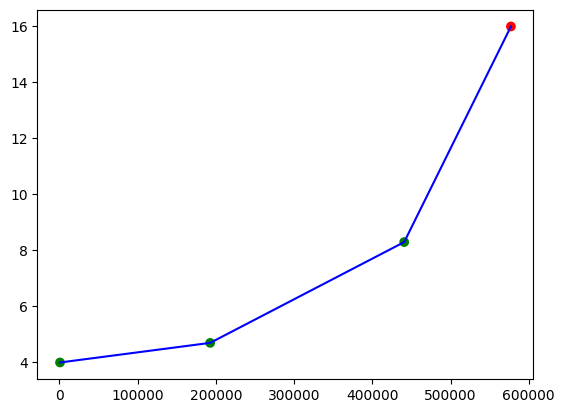

In [171]:
import matplotlib.pyplot as plt

sepsis_mask = grouped_multi_id_df[LABEL_COLUMN_NAME].apply(lambda x: "Sepsis" in x)
sepsis_time_stamps_df = grouped_multi_id_df[sepsis_mask]
control_time_stamps_df = grouped_multi_id_df[np.]

for row_idx in range(sepsis_time_stamps_df.shape[0]):
    row = sepsis_time_stamps_df.iloc[row_idx, :]
    time = np.asarray(row["Time"])
    wbc = np.asarray(row[WBC_COLUMN_NAME])
    plt_value = np.asarray(row[PLT_COLUMN_NAME])
    age = np.asarray(row[AGE_COLUMN_NAME])
    labels = np.asarray(row[LABEL_COLUMN_NAME])
    sorted_indices = np.argsort(time)
    
    sorted_time = time[sorted_indices]
    sorted_wbc = wbc[sorted_indices]
    sorted_labels = labels[sorted_indices]
    sorted_plt = plt_value[sorted_indices]
    sorted_age = age[sorted_indices]
    if sorted_labels[-1] != "Sepsis":
        print(sorted_labels)
    plt.scatter(sorted_time, sorted_wbc, color=["r" if label == "Sepsis" else "g" for label in sorted_labels])
#     plt.scatter(sorted_time, sorted_age, color=["r" if label == "Sepsis" else "g" for label in sorted_labels])
#     plt.scatter(sorted_time, sorted_plt, color=["r" if label == "Sepsis" else "g" for label in sorted_labels])
    plt.plot(sorted_time, sorted_wbc, "b-")
#     plt.plot(sorted_time, sorted_age, "g-")
#     plt.plot(sorted_time, sorted_plt, "y-")
    plt.show()
    if row_idx == 10:
        break

In [93]:
import time
for i in range(100):
    print("Waiting")
    time.sleep(60)

Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting


KeyboardInterrupt: 